# Table of Contents
* [Exploring science textbooks for parsing and annotations](#Exploring-science-textbooks-for-parsing-and-annotations)
	* [Intro](#Intro)
	* [basic parameters](#basic-parameters)
	* [Grouping texbooks by publisher](#Grouping-texbooks-by-publisher)
		* [groupings](#groupings)
	* [Testing pdf miner on single page](#Testing-pdf-miner-on-single-page)
		* [drawing bounding boxes over image](#drawing-bounding-boxes-over-image)
	* [Drawing sample pages for book categories](#Drawing-sample-pages-for-book-categories)
		* [a generic page from each category-](#a-generic-page-from-each-category-)
		* [a generic page from a single category](#a-generic-page-from-a-single-category)
	* [Draft Schema](#Draft-Schema)
	* [Proposal](#Proposal)
	* [JSON from MS OCR](#JSON-from-MS-OCR)
* [END](#END)
	* [experiments with parser settings and acrobat text recognition- abandoned for now](#experiments-with-parser-settings-and-acrobat-text-recognition--abandoned-for-now)


In [1]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
import cv2

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
from pdfminer.converter import TextConverter

In [4]:
from pdf_processing import draw_pdf_with_boxes
from pdf_processing import make_page_layouts

In [4]:
import json
import pprint

# Exploring science textbooks for parsing and annotations

## Intro

This notebook documents my eda on the k-12 science textbook dataset. In the 

## basic parameters

In [1]:
ls pdfs/ | wc -l 

      32


In [6]:
book_list = !ls pdfs/
book_list

['Barron\xe2\x80\x99s New York State Grade 4 Elementary-Level Science Test Joyce Thornton Barry  M. Ed. 288p 0764137344.pdf',
 'Confusing Science Terms, Grades 5 - 8 Schyrlet Cameron 80p 1580375111.pdf',
 'DK Workbooks  Science, Second Grade DK Publishing 60p 146541729X.pdf',
 'DK Workbooks  Science, Third Grade DK Publishing 60p 1465417303.pdf',
 'Daily Science, Grade 1 Evan Moor 192p 1596734191.pdf',
 'Daily Science, Grade 2 Evan Moor 192p 1596734205.pdf',
 'Daily Science, Grade 3 (Daily Practice Books) Evan-Moor Educational Publishers 192p 1596734213.pdf',
 'Daily Science, Grade 4 Evan Moor 192p 1596739282.pdf',
 'Daily Science, Grade 5 Evan Moor 192p 1596739290.pdf',
 'Daily Science, Grade 6 (Daily Practice Books) Evan Moor 192p 1596739304.pdf',
 'GED Science Exam Secrets Workbook  GED Test Practice Questions   Review for the General Educational Development Test (Mometrix Secrets Study Guides) GED Exam Secrets Test Prep Team 140p 1.pdf',
 'General Science, Grades 5 - 8 (Daily Skill

There are 28 total, with three distinct series.

In [7]:
total_page_count = 0
for textbook in book_list:
    test_book_path = './pdfs/' + textbook
    with open(test_book_path, 'r') as fp:
        parser = PDFParser(fp)
        document = PDFDocument(parser)
        total_page_count += len(list(PDFPage.create_pages(document)))
total_page_count

4686

There are 4686 total pages.

In [8]:
extractable = 0
for textbook in book_list:
    test_book_path = './pdfs/' + textbook
    with open(test_book_path, 'r') as fp:
        parser = PDFParser(fp)
        document = PDFDocument(parser)
        extractable += document.is_extractable
extractable

28

all of the documents are extractable!

!find ./pdfs/* | xargs -L 1 pdffonts

fonts and encodings are consistent

## Grouping texbooks by publisher

In [6]:
spectrum_science =  !ls pdfs/ | grep 'Spectrum Science'
book_breakdowns['spectrum_sci'] = spectrum_science
print('Spectrum Science,: ', len(spectrum_science), ' total')
# print('\n'.join(spectrum_science))

NameError: name 'book_breakdowns' is not defined

In [11]:
daily_science =  !ls pdfs/ | grep 'Daily Sc' 
book_breakdowns['daily_sci'] = daily_science
print('Daily Science: ', len(daily_science), ' total')
# print('\n'.join(daily_science))

('Daily Science: ', 6, ' total')


In [12]:
read_understand =  !ls pdfs/ | grep 'Read and Understand Science' 
book_breakdowns['read_und_sci'] = read_understand
print('Read and Understand Science: ', len(read_understand), ' total')
# print('\n'.join(read_understand))

('Read and Understand Science: ', 4, ' total')


In [13]:
workbooks =  !ls pdfs/ | grep -i  'workbook' 
book_breakdowns['workbooks'] = workbooks
print('workbooks: ', len(workbooks), ' total')
# print('\n'.join(workbooks))

('workbooks: ', 5, ' total')


In [14]:
for book in book_list:
    if not sum([book in series for series in book_breakdowns.values()]):
        book_breakdowns['misc'].append(book)

In [15]:
sum([len(books) for books in book_breakdowns.values()])

28

all books accounted for in groupings

### groupings

In [16]:
for group, books in book_breakdowns.items():
    print(group)
    print('\n'.join(books + [' ']))

daily_sci
Daily Science, Grade 1 Evan Moor 192p 1596734191.pdf
Daily Science, Grade 2 Evan Moor 192p 1596734205.pdf
Daily Science, Grade 3 (Daily Practice Books) Evan-Moor Educational Publishers 192p 1596734213.pdf
Daily Science, Grade 4 Evan Moor 192p 1596739282.pdf
Daily Science, Grade 5 Evan Moor 192p 1596739290.pdf
Daily Science, Grade 6 (Daily Practice Books) Evan Moor 192p 1596739304.pdf
 
misc
Barron’s New York State Grade 4 Elementary-Level Science Test Joyce Thornton Barry  M. Ed. 288p 0764137344.pdf
Confusing Science Terms, Grades 5 - 8 Schyrlet Cameron 80p 1580375111.pdf
General Science, Grades 5 - 8 (Daily Skill Builders) Wendi Silvano 96p 1580374840.pdf
STAAR Success Strategies Grade 5 Science Study Guide  STAAR Test Review for the State of Texas Assessments of Academic Readiness STAAR Exam Secrets Test Prep Team 80p 1627336753.pdf
Science Essentials, Grades 3-4 School Specialty Publishing 352p 0769660487.pdf
Steck-Vaughn GED  Test Preparation Student Edition Science 2014 

Read and understand science 4

Daily 6

Spectrum 6

Steck-Vaughn 6 (2 scanned)

Barons 2

DK workbooks 3

    Harcourt 4
    
    Mcgraw Hill 4
    
    California mcgraw hill 6

## Testing pdf miner on single page

This section has been superseded by the module I wrote for parsing.

In [17]:
# pages = []
# laparams = LAParams()
# device = PDFPageAggregator(rsrcmgr, laparams=laparams)
# interpreter = PDFPageInterpreter(rsrcmgr, device)
# for page in PDFPage.create_pages(document):
#     interpreter.process_page(page)
#     # receive the LTPage object for the page.
#     pages.append(device.get_result())

### drawing bounding boxes over image

In [18]:
page_file ='test_page.pdf'
page_layout = make_page_layout(page_file)
page_png_stream, y_height = make_png_stream(page_file)
page_img = make_open_cv_img(page_png_stream)

for box in page_layout._objs:
    lr, ul = get_bbox_tuple(box, y_height)
    cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    try:
        print(box.get_text())
    except AttributeError:
        pass
display(Image.fromarray(page_img, 'RGB'))

In [19]:
#  laparams = LAParams()
#     page_layouts = []
#     with open(pdf_file, 'r') as fp:
#         parser = PDFParser(fp)
#         document = PDFDocument(parser)
#         rsrcmgr = PDFResourceManager()
#         device = PDFPageAggregator(rsrcmgr, laparams=laparams)
#         interpreter = PDFPageInterpreter(rsrcmgr, device)
#         for page in PDFPage.create_pages(document):
#             interpreter.process_page(page)
#             layout = device.get_result()
#             page_layouts.append(layout)
#     return page_layouts

## Drawing sample pages for book categories

### a generic page from each category-

In [5]:
for group, books in book_breakdowns[:1].items():
    print(group)
    print('\n'.join(books[2:3] + [' ']))
    book_file ='./pdfs/' + books[2]
    draw_pdf_with_boxes(book_file, [51,51])

NameError: name 'book_breakdowns' is not defined

decent splitting params-
line_overlap=0.5,
 char_margin=2.0,
 line_margin=0.5,
 word_margin=0.2,
 boxes_flow=0.5

### a generic page from a single category

In [13]:
book_file = './pdfs/Daily_Science_Grade_2_Evan_Moor.pdf'

./pdfs/Daily_Science_Grade_2_Evan_Moor.pdf


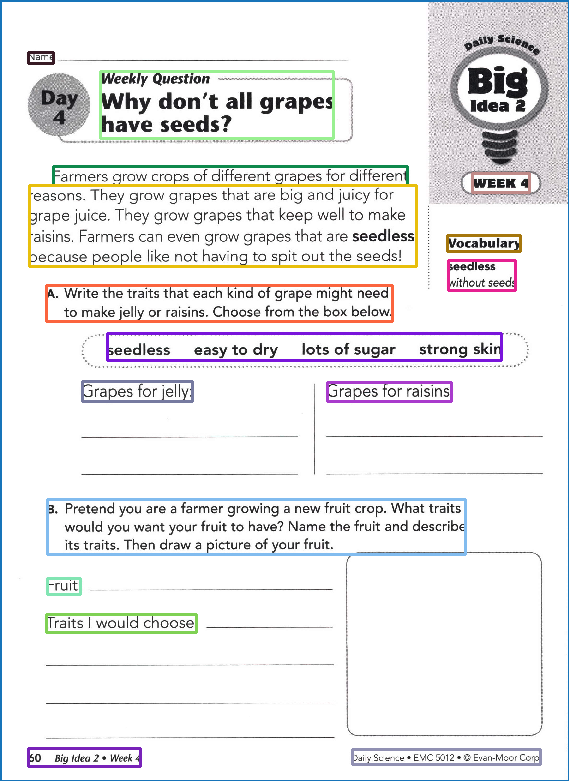

In [16]:
# for idx in range(len(book_breakdowns['daily_sci'])):
# book_file ='./pdfs/' + book_breakdowns['daily_sci'][idx]
print(book_file)
draw_pdf_with_boxes(book_file, [62,62])

## Draft Schema

header/topic

    -The page or section topic. This should be straightforward for turkers to recognize.

definition

    -The last page in the example above (How are living things different from nonliving things?) has a a good example--the vocab sidebar.

discussion

    - I envision this being the paragraph level discussion under a specific topic. This is by far the label with the most room for interpretation. I'm not sure what the right level of granularity is here. The paragraph is a nice easily identifiable block, but I could also see collapsing all of of the text under a topic (not falling under another label) into a single discussion blob.

question 

    - Text from a multiple choice, short answer, or fill-in-the-blank question. These three categories cover most questions, but there are some less frequent types, e.g. word find, word scramble, drawing connections. 

diagram

    - Diagram + figure labels and captions. 

other
    
    - Anything not covered by the above. Most of this should be structural or navigation related, e.g. page numbers, week/day headings.

## Proposal

The results above demonstrate that the textbooks are fairly consistent in their organization and page layouts. The three series of books from the same publisher should be a good place to start, as they're very consistent and cover over half of the textbooks collected.

Initially, I envision two rounds of mechanical turk annotations.
<br><br/>

    0. Pre-process the pdf-extraction in any way we can to simplify the turk tasks and reduce noise. This could include removing footers, table of contents (assuming we don't want those), and could even include programmatically joining some boxes.   

    1. Present a single page- label every box identified in the pdf extraction.


    2. Present boxes of a single category on a page- select boxes that should be grouped together or split. I'm not sure how difficult this would be to convey. The idea would be to join text separated or joined erroneously. In the examples above, this happens at paragraph indentations and many multi-line or fill-in-the-blank questions. 
    
If this sounds reasonable, I'll start prototyping the interface for the first turk task and generate some example results so you know what to expect. I envision the output being a json-

In [22]:
{
    "category_label": {
        "box_id": {
            "id": "D1",
            "text":"the contents of the text box",
            "source": ["textbook", "page_n"],
            "bounding_box": [
                [
                    400,
                    100
                ],
                [
                    500,
                    100
                ]
            ]
        }
    }
}

{'category_label': {'box_id': {'bounding_box': [[400, 100], [500, 100]],
   'id': 'D1',
   'source': ['textbook', 'page_n'],
   'text': 'the contents of the text box'}}}

## JSON from MS OCR

In [23]:
ls

exact_1.pdf@                    pdf_processing.pyc
exact_2.pdf@                    pdfs@
inter/                          single_page_test.pdf@
modules/                        spectrum_test.pdf
ocr_exp.ipynb                   test.png
parallel2_barrons_grade_4.json  test_page.pdf
pdf_processing.py@              textbook_eda.ipynb


In [24]:
with open('./parallel2_barrons_grade_4.json') as f:
    ms_ocr = json.load(f)

In [25]:
for box in ms_ocr[0]['content']['regions']:
    for line in  box['lines']:
        print ' '.join([word['text'] for word in line['words']])
        print '\n'

Sample Test 2 251


6. What type of a simple machine is shown below?


a. pulley


b. inclined plane


C. lever


d. wheel


7. The position or direction of an object can be changed


by applying


a. force.


b. magnetism.


C. chemical energy.


d. light energy.


8.


is a process by which plants and animals


Increase in size.


a. Growth


b. Adaptation


C. Migration


d. Variation


O Copyright 2007 by Barron's Educational Series, Inc.


Go On




In [26]:
# pprint.pprint(ms_ocr)

It looks like the ocr only covers the last 20 pages of the textbook which are practice tests (very clean). Not very informative of the feasibility of using the results.

# Extract images directly from pdf (instead of converting)

In [4]:
def make_page_layouts(pdf_file, page_range, line_overlap,
                      char_margin,
                      line_margin,
                      word_margin,
                      boxes_flow):
    laparams = LAParams(line_overlap, char_margin, line_margin, word_margin, boxes_flow)
    page_layouts = []
    with open(pdf_file, 'r') as fp:
        parser = PDFParser(fp)
        document = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page_n, page in enumerate(PDFPage.create_pages(document)):
            if not page_range:
                interpreter.process_page(page)
                layout = device.get_result()
                page_layouts.append(layout)
            elif page_range[0] <= page_n <= page_range[1]:
                interpreter.process_page(page)
                layout = device.get_result()
                page_layouts.append(layout)
    return page_layouts

In [5]:
test_book = './pdfs/Spectrum_Science_Grade_3.pdf'

In [53]:
sample_layout = make_page_layouts(test_book, [1,1], word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5)[0]

In [54]:
tg1 = sample_layout._objs

In [55]:
tf1 = tg1[-2]

In [56]:
ti1 = tf1._objs[0]

In [57]:
ti1

<LTImage(Obj12) 0.000,0.000,579.600,781.200 (2415, 3255)>

In [51]:
[det for det in tg1 if type(det) == pdfminer.layout.LTFigure][0]

<LTFigure(Obj12) 0.000,0.000,579.600,781.200 matrix=[579.60,0.00,0.00,781.20, (0.00,0.00)]>

In [49]:
pdfminer.layout.LTFigure

pdfminer.layout.LTFigure

In [46]:
te(tg1[-2])hdistance()

NameError: name 'hdistance' is not defined

In [17]:
file_stream = ti1.stream.get_rawdata()
first_four = file_stream[0:4]
determine_image_type(first_four)

NameError: name 'determine_image_type' is not defined

In [77]:
save_image(ti1, 149, 'images')

'149_Obj1048.jpeg'

In [76]:
import sys
import os
from binascii import b2a_hex

def determine_image_type (stream_first_4_bytes):
    """Find out the image file type based on the magic number comparison of the first 4 (or 2) bytes"""
    file_type = None
    bytes_as_hex = b2a_hex(stream_first_4_bytes)
    if bytes_as_hex.startswith('ffd8'):
        file_type = '.jpeg'
    elif bytes_as_hex == '89504e47':
        file_type = '.png'
    elif bytes_as_hex == '47494638':
        file_type = '.gif'
    elif bytes_as_hex.startswith('424d'):
        file_type = '.bmp'
    return file_type

def save_image (lt_image, page_number, images_folder):
    """Try to save the image data from this LTImage object, and return the file name, if successful"""
    result = None
    if lt_image.stream:
        file_stream = lt_image.stream.get_rawdata()
        if file_stream:
            file_ext = determine_image_type(file_stream[0:4])
            if file_ext:
                file_name = ''.join([str(page_number), '_', lt_image.name, file_ext])
                if write_file(images_folder, file_name, file_stream, flags='wb'):
                    result = file_name
    return result


def write_file (folder, filename, filedata, flags='w'):
    """Write the file data to the folder and filename combination
    (flags: 'w' for write text, 'wb' for write binary, use 'a' instead of 'w' for append)"""
    result = False
    if os.path.isdir(folder):
        try:
            file_obj = open(os.path.join(folder, filename), flags)
            file_obj.write(filedata)
            file_obj.close()
            result = True
        except IOError:
            pass
    return result

In [ ]:
draw_pdf_with_boxes(test_book, [149,149], word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5)

# END

## experiments with parser settings and acrobat text recognition- abandoned for now

In [27]:
# line_overlap=0.5,
#                  char_margin=2.0,
#                  line_margin=0.5,
#                  word_margin=0.1,
#                  boxes_flow=0.5,

# book_file = 'exact_1.pdf'
# draw_pdf_with_boxes(book_file, 0)

# book_file = 'single_page_test.pdf'
# draw_pdf_with_boxes(book_file, 0, 
#                 line_overlap=0.5,
#                  char_margin=2.,
#                  line_margin=0.9,
#                  word_margin=0.1, #no affect
#                  boxes_flow=1.0 )# no affect

# # tpl1 = make_page_layouts('single_page_test.pdf', 0)
# tpl1 = make_page_layouts(book_file, 0, 
#              line_overlap=0.5,
#                  char_margin=2.5,
#                  line_margin=0.9,
#                  word_margin=0.1, #no affect
#                  boxes_flow=0.5 )# no affect

# tpl1_boxes = tpl1[0]._objs
# tpl1_boxes

In [28]:
# book_ocr_comp = './pdfs/' + book_breakdowns['misc'][0]
# draw_pdf_with_boxes(book_ocr_comp, [134,135])